# Importing necessary libraries

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [9]:
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#  Data Loading and Inspection



> Load the MPU dataset and display basic information to understand the structure and data types, as well as summary statistics to get an overview of the data.



In [10]:
df = pd.read_excel("D:\الكليه\Project 3\Motion-Correctness-Classification\data\mpuData.xlsx")

In [11]:
df.head()

,Movement_Name,Movement_Label,Label_Value,Joint_Label,Pitch,Roll,AccelX,AccelY,AccelZ
0,Stretching,True,1,Shoulder,-0.25,-0.01,-0.02,0.01,9.78
1,Stretching,True,1,Elbow,0.91,-0.17,-0.03,0.00,9.77
2,Stretching,True,1,Wrist,0.57,-0.12,-0.02,0.03,9.75
3,Stretching,True,1,Hand,0.71,-0.11,-0.04,0.05,9.72
4,Stretching,True,1,Shoulder,0.25,-0.07,-0.02,0.02,9.77


In [12]:
df.tail()

,Movement_Name,Movement_Label,Label_Value,Joint_Label,Pitch,Roll,AccelX,AccelY,AccelZ
191,Stretching,False,0,Hand,0.74,3.02,0.52,-0.10,10.42
192,Stretching,False,0,Shoulder,-0.80,0.95,0.26,-0.26,9.91
193,Stretching,False,0,Elbow,0.12,3.24,0.82,0.11,10.27
194,Stretching,False,0,Wrist,-0.13,4.38,0.95,-0.19,10.48
195,Stretching,False,0,Hand,0.59,3.15,0.50,-0.13,10.40


In [13]:
df.sample()

,Movement_Name,Movement_Label,Label_Value,Joint_Label,Pitch,Roll,AccelX,AccelY,AccelZ
4,Stretching,True,1,Shoulder,0.25,-0.07,-0.02,0.02,9.77


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Movement_Name   196 non-null    object 
 1   Movement_Label  196 non-null    bool   
 2   Label_Value     196 non-null    int64  
 3   Joint_Label     196 non-null    object 
 4   Pitch           196 non-null    float64
 5   Roll            196 non-null    float64
 6   AccelX          196 non-null    float64
 7   AccelY          196 non-null    float64
 8   AccelZ          196 non-null    float64
dtypes: bool(1), float64(5), int64(1), object(2)
memory usage: 12.6+ KB


### Descriptive statistics

In [15]:
df.describe()

,Label_Value,Pitch,Roll,AccelX,AccelY,AccelZ
count,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000
mean,0.489796,-0.261327,2.291327,0.730255,-0.100408,10.104184
std,0.501176,0.867205,1.888887,0.539372,0.205964,0.383193
min,0.000000,-2.240000,-1.610000,-1.000000,-0.570000,8.940000
25%,0.000000,-0.757500,0.780000,0.317500,-0.220000,9.852500
50%,0.000000,-0.235000,2.040000,0.800000,-0.105000,10.240000
75%,1.000000,0.160000,3.460000,1.082500,0.020000,10.392500
max,1.000000,3.350000,7.740000,1.830000,0.510000,10.590000


### Class balance check

In [16]:
df['Movement_Label'].value_counts()

Movement_Label
False    100
True      96
Name: count, dtype: int64

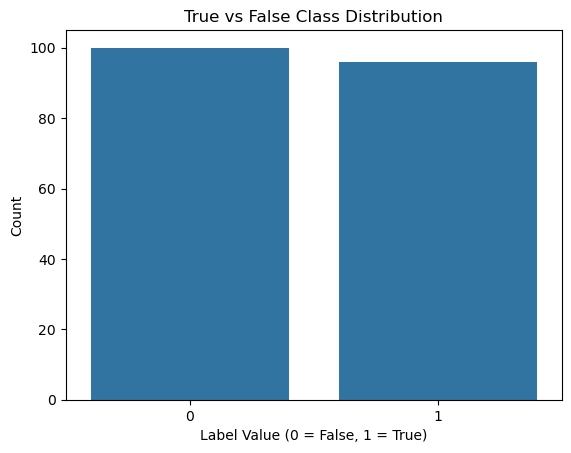

In [17]:
sns.countplot(x="Label_Value", data=df)
plt.title("True vs False Class Distribution")
plt.xlabel("Label Value (0 = False, 1 = True)")
plt.ylabel("Count")
plt.show()

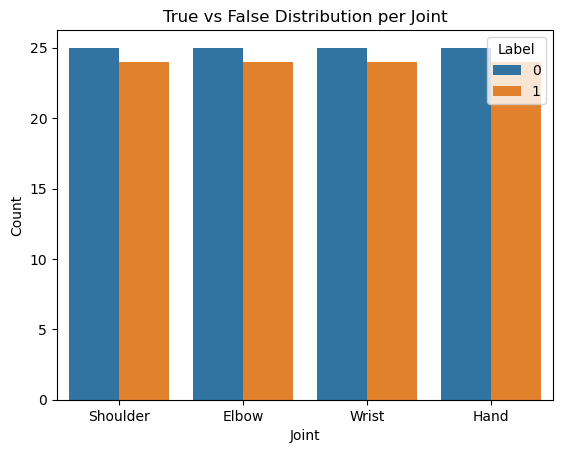

In [18]:
sns.countplot(
    x="Joint_Label",
    hue="Label_Value",
    data=df
)
plt.title("True vs False Distribution per Joint")
plt.xlabel("Joint")
plt.ylabel("Count")
plt.legend(title="Label")
plt.show()


## Data Preprocessing

### Feature Scaling Using StandardScaler

In [19]:
from sklearn.preprocessing import StandardScaler

In [20]:
# Select numerical feature columns to be scaled
numerical_features = [
    "Pitch",
    "Roll",
    "AccelX",
    "AccelY",
    "AccelZ"
]

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply scaling to the numerical features
df[numerical_features] = scaler.fit_transform(df[numerical_features])
df.head()

,Movement_Name,Movement_Label,Label_Value,Joint_Label,Pitch,Roll,AccelX,AccelY,AccelZ
0,Stretching,True,1,Shoulder,0.013094,-1.221471,-1.394540,0.537427,-0.848173
1,Stretching,True,1,Elbow,1.354151,-1.306394,-1.413128,0.488751,-0.874336
2,Stretching,True,1,Wrist,0.961082,-1.279855,-1.394540,0.634780,-0.926663
3,Stretching,True,1,Hand,1.122934,-1.274547,-1.431715,0.732133,-1.005153
4,Stretching,True,1,Shoulder,0.591136,-1.253317,-1.394540,0.586103,-0.874336


## Feature Engineering

In [21]:
# Calculate acceleration magnitude to represent motion intensity
df['Accel_Mag'] = np.sqrt(
    df['AccelX']**2 +
    df['AccelY']**2 +
    df['AccelZ']**2
)

In [22]:
# Calculate absolute difference between Pitch and Roll
df['Angle_Diff'] = np.abs(df['Pitch'] - df['Roll'])
df.head() 

,Movement_Name,Movement_Label,Label_Value,Joint_Label,Pitch,Roll,AccelX,AccelY,AccelZ,Accel_Mag,Angle_Diff
0,Stretching,True,1,Shoulder,0.013094,-1.221471,-1.394540,0.537427,-0.848173,1.718420,1.234565
1,Stretching,True,1,Elbow,1.354151,-1.306394,-1.413128,0.488751,-0.874336,1.732129,2.660544
2,Stretching,True,1,Wrist,0.961082,-1.279855,-1.394540,0.634780,-0.926663,1.790640,2.240938
3,Stretching,True,1,Hand,1.122934,-1.274547,-1.431715,0.732133,-1.005153,1.896354,2.397481
4,Stretching,True,1,Shoulder,0.591136,-1.253317,-1.394540,0.586103,-0.874336,1.747205,1.844453


In [23]:

joint_agg = df.groupby(['Movement_Name', 'Joint_Label', 'Label_Value']).agg({
    'AccelX': ['mean', 'std'],
    'AccelY': ['mean', 'std'],
    'AccelZ': ['mean', 'std'],
    'Pitch': ['mean', 'std'],
    'Roll': ['mean', 'std'],
    'Accel_Mag': ['mean', 'std'],
    'Angle_Diff': ['mean', 'std']
}).reset_index()

# Flatten columns
joint_agg.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in joint_agg.columns]

# Rename Label_Value to Target
joint_agg.rename(columns={'Label_Value': 'Target'}, inplace=True)


print("New counts in joint_agg:")
print(joint_agg['Target'].value_counts())

New counts in joint_agg:
Target
0    8
1    8
Name: count, dtype: int64


### Train-Test Split & Preprocessing (One-Hot Encoding for Joint Labels)

In [28]:
# 1. Encoding using OneHotEncoder 
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
# Apply to aggregated data
joint_encoded = encoder.fit_transform(joint_agg[['Joint_Label']])
joint_encoded_df = pd.DataFrame(joint_encoded, columns=encoder.get_feature_names_out(['Joint_Label']))

# Combine it back
X = pd.concat([joint_agg.drop(['Movement_Name', 'Joint_Label', 'Target'], axis=1), joint_encoded_df], axis=1)
y = joint_agg['Target']

# 2. Train-Test Split (Keep the distribution with Stratify)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=7, stratify=y)
# 3. Scaling (Essential for Accuracy)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Data is split and scaled. Ready for training!")

✅ Data is split and scaled. Ready for training!


In [43]:
import warnings


# Suppress warnings for a clean output
warnings.filterwarnings('ignore')

--- 1. Generating Confusion Matrices (Quick Test) ---


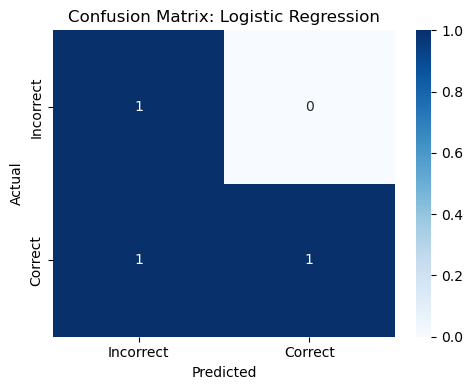

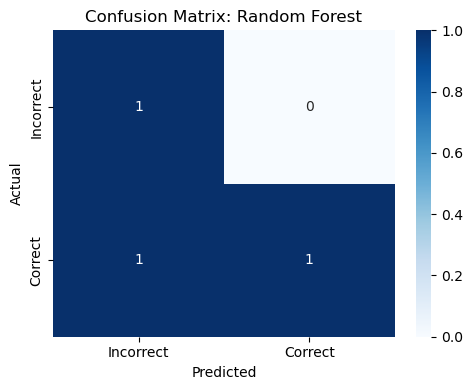

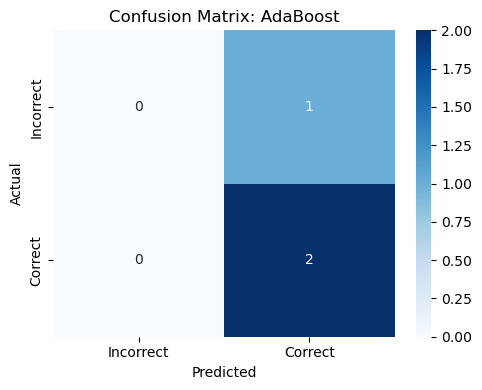

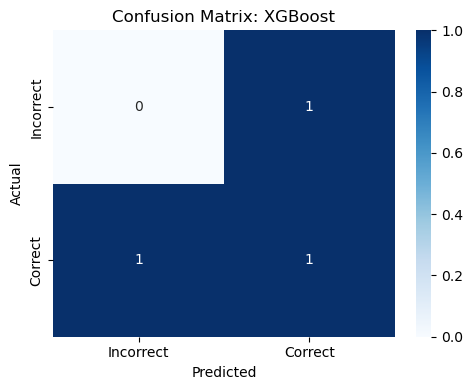


--- 2. Performing Cross-Validation (Deep Evaluation) ---

--- Final Cross-Validation Results ---


,Model Name,Avg Accuracy,Avg Precision,Avg Recall,Avg F1-score
0,Logistic Regression,0.933333,1.0,0.9,0.933333
1,Random Forest,0.700000,0.5,0.5,0.500000
2,AdaBoost,0.666667,0.7,0.7,0.666667
3,XGBoost,0.633333,0.6,0.7,0.600000


In [44]:
# 1. Initialize models with fixed parameters for compatibility
from sklearn.model_selection import cross_validate


models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=10, max_depth=3, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42, algorithm='SAMME'),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}

# Lists to store metrics
quick_results = []
cv_results_list = []

print("--- 1. Generating Confusion Matrices (Quick Test) ---")

# 2. Training and Visualization Loop (Quick Evaluation)
for name, model in models.items():
    # Train the model on the training set
    model.fit(X_train_scaled, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)
    
    # Store quick metrics
    metrics = {
        "Model Name": name,
        "Test Accuracy": accuracy_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred, zero_division=0)
    }
    quick_results.append(metrics)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Incorrect', 'Correct'], 
                yticklabels=['Incorrect', 'Correct'])
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

print("\n--- 2. Performing Cross-Validation (Deep Evaluation) ---")

# 3. Deep Evaluation using K-Fold Cross-Validation
for name, model in models.items():
    # cv=5 provides a reliable average across 5 different data splits
    cv_output = cross_validate(model, X_train_scaled, y_train, cv=5, 
                                 scoring=['accuracy', 'f1', 'precision', 'recall'])
    
    res = {
        "Model Name": name,
        "Avg Accuracy": cv_output['test_accuracy'].mean(),
        "Avg Precision": cv_output['test_precision'].mean(),
        "Avg Recall": cv_output['test_recall'].mean(),
        "Avg F1-score": cv_output['test_f1'].mean()
    }
    cv_results_list.append(res)

# 4. Display the Final Comparison Table
cv_results_df = pd.DataFrame(cv_results_list)
print("\n--- Final Cross-Validation Results ---")
display(cv_results_df)

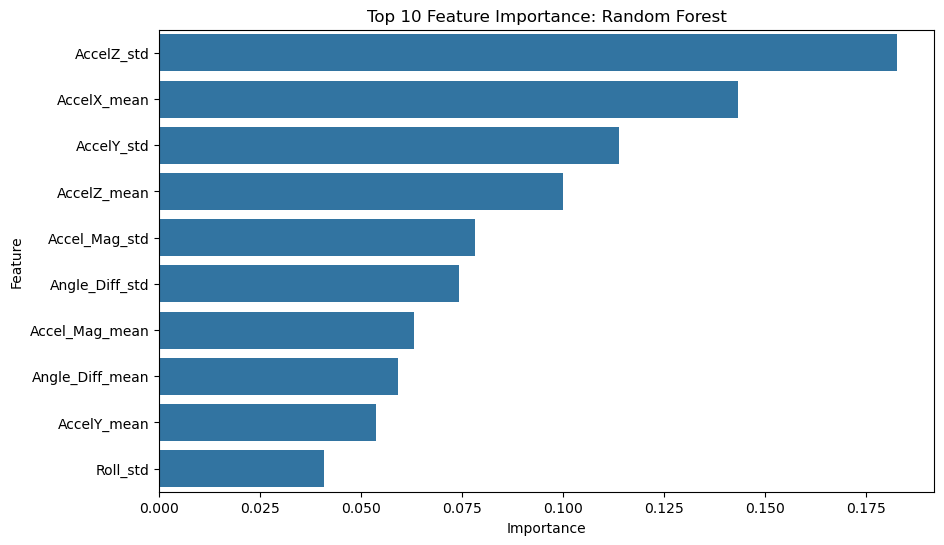

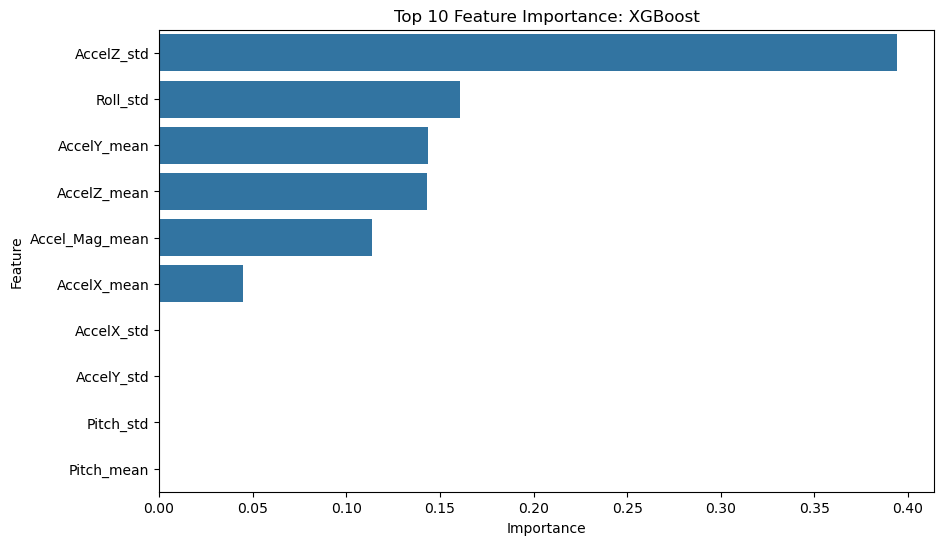

In [45]:
# --- Feature Importance for Tree-Based Models ---
tree_models = ["Random Forest", "XGBoost"]

for name in tree_models:
    plt.figure(figsize=(10, 6))
    importances = models[name].feature_importances_
    feat_names = X.columns
    
    importance_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
    
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
    plt.title(f'Top 10 Feature Importance: {name}')
    plt.show()

In [46]:
# 6. Select and Save the Best Model
# --------------------------------
import os
# Identify the best model

best_model_idx = cv_results_df['Avg F1-score'].idxmax()
best_model_name = cv_results_df.loc[best_model_idx, 'Model Name']
best_model = models[best_model_name]

print(f"🏆 Final Decision: The best model is '{best_model_name}'")

# NEW: Create 'models' directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')
    print("📁 Created 'models' directory")

# Define filenames
model_path = 'models/final_motion_classifier.joblib'
scaler_path = 'models/motion_scaler.joblib'

# Export
joblib.dump(best_model, model_path)
joblib.dump(scaler, scaler_path)

print(f"✅ Success: Best Model saved to: {model_path}")
print(f"✅ Success: Scaler saved to: {scaler_path}")

🏆 Final Decision: The best model is 'Logistic Regression'
✅ Success: Best Model saved to: models/final_motion_classifier.joblib
✅ Success: Scaler saved to: models/motion_scaler.joblib
